# Лабораторная работа №6

### Вариант №4

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np

# Параметры задачи
a = 1.0  # Коэффициент уравнения
T = 5    # Время окончания расчета
l0 = 0   # Левый край отрезка
l1 = 1   # Правый край отрезка

# Начальные условия
def psi_1(x):
    # Первое начальное условие: u(x, 0)
    return math.exp(2*x)

def psi_2(x):
    # Второе начальное условие: u_t(x, 0)
    return 0

def dpsi1_dx2(x):
    # Вторая производная функции psi_1(x) по x: d^2u/dx^2 в начальный момент времени
    return 4*math.exp(2*x)

# Аналитическое решение задачи
def u(x, t):
    # Аналитическое решение: U(x, t) = exp(2x) * cos(t)
    return math.exp(2*x)*math.cos(t)

# Генерация списка чисел на равномерной сетке
def nums_list(start, end, step = 1, eps = 0.00000000001):
    res = []
    current = start

    while abs(current - eps) <= end:  # Учитываем погрешность для чисел с плавающей точкой
        res.append(current)
        current += step

    return res

## Конечно-разностная схема

In [11]:
# Абстрактный класс для реализации конечно-разностной схемы
class abstract_scheme:
    def __init__(self, 
                 psi1=psi_1,               # Первое начальное условие u(x, 0)
                 psi2=psi_2,               # Второе начальное условие u_t(x, 0)
                 diff2psi1=dpsi1_dx2,      # Вторая производная psi_1 по x
                 l0=l0,                    # Левый край отрезка
                 l1=l1,                    # Правый край отрезка
                 T=T,                      # Время окончания расчета
                 approx_scale_second_layer='first', # Тип аппроксимации второго слоя
                 approx_scheme=None):      # Схема аппроксимации для граничных условий
        self.psi1 = psi1
        self.diff2psi1 = diff2psi1
        self.psi2 = psi2
        self.T = T
        self.l0 = l0
        self.l1 = l1
        self.tau = None                  # Шаг по времени
        self.h = None                    # Шаг по пространству
        self.approx = None               # Схема аппроксимации граничных условий
        self.approx_scale_second_layer = approx_scale_second_layer
        if approx_scheme is not None:
            self.approx = approx_scheme()
        self.sigma = None                # Число Куранта
        
    # Метод для вычисления следующего временного слоя (должен быть реализован в наследниках)
    def next_layer(self, t, x, last_line1, last_line2):
        pass
    
    # Основной метод вычисления решения задачи
    def __call__(self, N=50, K=1100, tau=None, h=None, sigma=None):
        if N is not None and K is not None:
            if tau is not None:
                self.tau = tau  # Шаг по времени
            else:
                self.tau = self.T / (K-1)
            if h is not None:
                self.h = h  # Шаг по пространству
            else:
                self.h = (self.l1 - self.l0) / (N-1)
        if sigma is not None:  # Если задано число Куранта
            self.sigma = sigma
            if K is not None and N is None:  # Если задано число временных слоев, но не пространственных
                self.tau = self.T / (K-1)
                self.h = math.sqrt(self.tau * self.tau / self.sigma)
            elif N is not None and K is None:  # Если задано число пространственных узлов, но не временных
                self.h = (self.l1 - self.l0) / (N-1)
                self.tau = math.sqrt(self.sigma * self.h * self.h)
        else:
            self.sigma = self.tau * self.tau / (self.h * self.h)
            
        ans = []  # Список для хранения решений на каждом временном слое

        x = nums_list(self.l0, self.l1, self.h)  # Узлы по пространству
        
        # Вычисление решения на первом временном слое
        last_line = list(map(self.psi1, x))
        ans.append(list(last_line))

        # Вычисление решения на втором временном слое
        if self.approx_scale_second_layer == 'second':  # Если используется аппроксимация второго порядка
            last_line = list(map(lambda a: self.psi1(a) + self.tau*self.psi2(a) + 0.5 * self.tau * self.tau * 
                                 (self.diff2psi1(a) - 5 * self.psi1(a)), x))
        else:  # Если используется аппроксимация первого порядка
            last_line = list(map(lambda a: self.psi1(a) + self.tau*self.psi2(a), x))
        ans.append(list(last_line))

        # Вычисление решения на остальных временных слоях
        for t in nums_list(self.tau * 2, self.T, self.tau):
            ans.append(self.next_layer(t, x, ans[-1], ans[-2]))

        return ans
    
# Класс для точного решения уравнения (аналитическое решение)
class exact_solution:
    def __init__(self, 
                 l0=l0,     # Левый край отрезка
                 l1=l1,     # Правый край отрезка
                 T=T,       # Время окончания расчета
                 exact_f=u): # Аналитическая функция u(x, t)
        self.l0 = l0
        self.l1 = l1
        self.T = T
        self.exact_f = exact_f
        
    # Метод вычисления точного решения на равномерной сетке
    def __call__(self, N=50, K=1100, h=None, tau=None, sigma=None):    
        if N is not None and K is not None:    
            if h is None:
                h = (self.l1 - self.l0) / (N-1)  # Шаг по пространству
            if tau is None:
                tau = self.T / (K-1)  # Шаг по времени
        elif sigma is not None:  # Если задано число Куранта
            if K is not None and N is None:  # Если задано число временных слоев, но не пространственных
                tau = self.T / (K-1)
                h = math.sqrt(tau * tau / sigma)
            elif N is not None and K is None:  # Если задано число пространственных узлов, но не временных
                h = (self.l1 - self.l0) / (N-1)
                tau = math.sqrt(sigma * h**2)
                
        ans = []  # Список для хранения решений на каждом временном слое
        
        for t in nums_list(0, self.T, tau):  # По временной сетке
            cur_layer = []

            for x in nums_list(self.l0, self.l1, h):  # По пространственной сетке
                cur_layer.append(self.exact_f(x, t))  # Вычисляем аналитическое решение
            ans.append(cur_layer)

        return ans

## Явная конечно-разностная схема 

In [12]:
class explicit_scheme(abstract_scheme):
    def next_layer(self, t, x, last_line1, last_line2):
        if (self.sigma > 1.0):
            # Проверка условия устойчивости для явной схемы
            raise Exception("sigma > 1.0")  
        line = [None for _ in last_line1]  # Новый временной слой (заполняется далее)

        # Вычисление внутренних точек слоя
        for i in range(1, len(x) - 1):
            # Формула явной конечно-разностной схемы
            line[i] = (
                self.sigma * (last_line1[i-1] - 2 * last_line1[i] + last_line1[i+1]) 
                - 5 * self.tau * self.tau * last_line1[i] 
                + 2 * last_line1[i] - last_line2[i]
            )

        # Аппроксимация граничных условий
        line[0] = self.approx.explict_0(self.h, self.sigma, line, last_line1, last_line2, self.tau)
        line[-1] = self.approx.explict_l(self.h, self.sigma, line, last_line1, last_line2, self.tau)

        return line  # Возвращаем вычисленный слой

## Неявная конечно-разностная схема

In [13]:
# Метод прогонки для решения трехдиагональной системы
def tridiagonal_matrix_method(A, B):
    """
    Решает трехдиагональную систему методом прогонки.
    A - массив коэффициентов трехдиагональной матрицы: (a, b, c) для каждого уравнения
    B - правая часть системы
    """
    P = [-item[2] for item in A]  # Прогоночные коэффициенты P
    Q = [item for item in B]     # Прогоночные коэффициенты Q

    # Прямой ход прогонки
    P[0] /= A[0][1]
    Q[0] /= A[0][1]
    for i in range(1, len(B)):
        z = (A[i][1] + A[i][0] * P[i-1])  # Делитель для нормализации
        P[i] /= z
        Q[i] -= A[i][0] * Q[i-1]
        Q[i] /= z

    # Обратный ход прогонки
    x = [item for item in Q]
    for i in range(len(x) - 2, -1, -1):
        x[i] += P[i] * x[i + 1]

    return x  # Решение системы

# Класс для неявной конечно-разностной схемы
class implict_scheme(abstract_scheme):
    def next_layer(self, t, x, last_line1, last_line2):
        a = 1  # Коэффициент при u_{i-1}
        b = -2 - 5 * self.h * self.h - 1 / self.sigma  # Коэффициент при u_i
        c = 1  # Коэффициент при u_{i+1}

        # Формирование трехдиагональной матрицы A и правой части B для внутренней области
        A = [(a, b, c) for _ in range(1, len(x) - 1)]
        B = [(last_line2[i] - 2 * last_line1[i]) / self.sigma for i in range(1, len(x) - 1)]

        # Учет граничных условий с использованием схемы аппроксимации
        koeffs = self.approx.implict_0(self.h, self.sigma, last_line1, last_line2)
        A.insert(0, koeffs[:-1])  # Добавляем уравнение для левой границы
        B.insert(0, koeffs[-1])  # Правая часть уравнения для левой границы

        koeffs = self.approx.implict_l(self.h, self.sigma, last_line1, last_line2)
        A.append(koeffs[:-1])  # Добавляем уравнение для правой границы
        B.append(koeffs[-1])  # Правая часть уравнения для правой границы

        # Решаем систему методом прогонки
        return tridiagonal_matrix_method(A, B)

## Апроксимация

In [14]:
# Абстрактный класс для аппроксимации граничных условий
class abstract_approx:
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        # Аппроксимация для левой границы в явной схеме
        pass

    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        # Аппроксимация для правой границы в явной схеме
        pass

    def implict_0(self, h, sigma, l0, l1):
        # Аппроксимация для левой границы в неявной схеме
        pass

    def implict_l(self, h, sigma, l0, l1):
        # Аппроксимация для правой границы в неявной схеме
        pass

# Двухточечная аппроксимация первого порядка
class approx_two_one(abstract_approx):
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        # Левое граничное условие для явной схемы
        return line[1] / (1 + 2 * h)

    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        # Правое граничное условие для явной схемы
        return line[-2] / (1 - 2 * h)

    def implict_0(self, h, sigma, l0, l1):
        # Левое граничное условие для неявной схемы
        return 0, (1 + 2 * h), -1, 0

    def implict_l(self, h, sigma, l0, l1):
        # Правое граничное условие для неявной схемы
        return -1, (1 - 2 * h), 0, 0

# Трехточечная аппроксимация второго порядка
class approx_three_two(abstract_approx):
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        # Левое граничное условие для явной схемы
        return (4 * line[1] - line[2]) / (3 + 4 * h)

    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        # Правое граничное условие для явной схемы
        return (4 * line[-2] - line[-3]) / (3 - 4 * h)

    def implict_0(self, h, sigma, l0, l1):
        # Левое граничное условие для неявной схемы
        return 0, -(2 + 4 * h), -(5 * h * h + 1 / sigma - 2), (-2 * l0[1] + l1[1]) / sigma

    def implict_l(self, h, sigma, l0, l1):
        # Правое граничное условие для неявной схемы
        return -(5 * h * h + 1 / sigma - 2), -(2 - 4 * h), 0, (-2 * l0[-2] + l1[-2]) / sigma

# Двухточечная аппроксимация второго порядка
class approx_two_two(abstract_approx):
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        # Левое граничное условие для явной схемы
        return sigma * (2 * last_line1[1] - (2 + 4 * h) * last_line1[0]) + \
               (2 - 5 * tau * tau) * last_line1[0] - last_line2[0]

    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        # Правое граничное условие для явной схемы
        return sigma * (2 * last_line1[-2] + (4 * h - 2) * last_line1[-1]) + \
               (2 - 5 * tau * tau) * last_line1[-1] - last_line2[-1]

    def implict_0(self, h, sigma, l0, l1):
        # Левое граничное условие для неявной схемы
        return 0, -(2 + 5 * h * h + 4 * h + 1 / sigma), 2, (-2 * l0[0] + l1[0]) / sigma

    def implict_l(self, h, sigma, l0, l1):
        # Правое граничное условие для неявной схемы
        return 2, -(2 + 5 * h * h - 4 * h + 1 / sigma), 0, (-2 * l0[-1] + l1[-1]) / sigma

## Зависимость погрешности от параметров t и h

In [15]:
# Функция для вычисления среднего квадратичного отклонения погрешности
def calculate_mean_error(ans, exact_ans):
    """
    Вычисляет среднеквадратичную ошибку между численным и аналитическим решениями.
    ans - численное решение
    exact_ans - аналитическое решение
    """
    mean_error = []  # Список для хранения ошибки на каждом временном слое

    for t in range(len(ans)):  # Проходим по всем временным слоям
        n = len(ans[t])  # Количество узлов по пространству
        sum_abs = 0.0  # Переменная для накопления суммы квадратов ошибок

        for i in range(len(ans[t])):  # Проходим по всем пространственным узлам
            # Считаем квадрат отклонения между численным и аналитическим решением
            sum_abs += ((ans[t][i] - exact_ans[t][i]) / math.sqrt(n)) ** 2
        # Считаем среднеквадратичную ошибку для текущего временного слоя
        mean_error.append(math.sqrt(sum_abs))
        
    return mean_error

# Функция для вычисления ошибки в зависимости от времени
def get_error_by_t(solver, exact_solution, N=50, K=1100, sigma=None):
    """
    Вычисляет погрешность решения для заданного числа пространственных (N) и временных (K) узлов
    или числа Куранта (sigma).
    solver - численный метод решения
    exact_solution - аналитическое решение
    """
    # Получаем численное решение
    ans = solver(N=N, K=K, sigma=sigma)
    # Получаем аналитическое решение
    exact_ans = exact_solution(N=N, K=K, sigma=sigma)
    
    # Возвращаем рассчитанную среднеквадратичную ошибку
    return calculate_mean_error(ans, exact_ans)

# Установка параметров для анализа ошибок
T_difference_by_t = 10  # Временной интервал
K = 1000  # Количество временных шагов

# Расчет шага по времени
tau = T_difference_by_t / (K - 1)
# Генерация временной сетки
t = nums_list(0, T_difference_by_t, tau)

# Создание объекта для аналитического решения
exact_by_t = exact_solution(T=T_difference_by_t)

def print_error(error):
    max_error = max(error)

    print(round(max_error, 3))


# Функция для вычисления максимальной абсолютной ошибки
def calculate_error(ans, exact_ans):
    """
    Вычисляет максимальную абсолютную ошибку между численным и аналитическим решениями.
    ans - численное решение
    exact_ans - аналитическое решение
    """
    max_abs = 0.0  # Переменная для хранения максимальной ошибки
    for i in range(len(ans)):  # По всем временным слоям
        for j in range(len(ans[i])):  # По всем пространственным узлам
            eps = abs(ans[i][j] - exact_ans[i][j])  # Абсолютное значение разницы
            max_abs = max(max_abs, eps)  # Обновляем максимум
    return max_abs

# Функция для вычисления ошибки в зависимости от шага h
def get_error_by_h(solver, exact_solution, N=70, K=1100, sigma=None):
    """
    Возвращает зависимость ошибки от шага h.
    solver - численный метод решения
    exact_solution - аналитическое решение
    N - максимальное количество узлов по пространству
    K - количество временных слоев
    sigma - число Куранта
    """
    h_array = []  # Список для хранения значений h
    error = []    # Список для хранения ошибок
    for n in range(20, N):  # Варьируем количество узлов по пространству
        ans = solver(K=K, N=n, sigma=sigma)  # Численное решение
        exact_ans = exact_solution(K=K, N=n, sigma=sigma)  # Аналитическое решение
        h_array.append(solver.h)  # Добавляем шаг h
        error.append(calculate_error(ans, exact_ans))  # Добавляем ошибку
        
    return h_array, error

# Создание объекта аналитического решения для T = 5
exact_by_h = exact_solution(T=5)


N = 20

h = (l1 - l0) / (N-1)
x = nums_list(l0, l1, h)

exact_approx = exact_solution()
exact_approx_ans = exact_approx(N = N)

## Функции для построения графиков

In [16]:
def plot_error_by_t(scheme_function, approx_schemes, T, exact_solution, K, title, t, colors, labels):
    """
    Построение графиков зависимости ошибки от времени для заданной численной схемы.

    :param scheme_function: функция численной схемы (например, `explicit_scheme`).
    :param approx_schemes: список аппроксимационных схем (например, [approx_two_one, approx_two_two, approx_three_two]).
    :param T: параметры временного шага.
    :param exact_solution: функция реального решения.
    :param K: количество временных шагов.
    :param title: заголовок графика.
    :param t: массив времени.
    :param colors: список цветов для каждой аппроксимационной схемы.
    :param labels: список меток для каждой аппроксимационной схемы.
    """
    errors = []
    
    # Вычисление ошибок для каждой аппроксимационной схемы
    for approx_scheme in approx_schemes:
        scheme = scheme_function(T=T, approx_scheme=approx_scheme)
        error = get_error_by_t(scheme, exact_solution, K=K)
        errors.append(error)
    
    # Построение графика
    plt.figure(figsize=(16, 10))
    plt.title(title)

    for i, error in enumerate(errors):
        plt.plot(t, error, label=labels[i], color=colors[i])

    plt.xlabel("t")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.grid()
    plt.show()

def plot_error_by_h(scheme_function, approx_schemes, T, exact_solution, sigma, title, colors, labels):
    """
    Построение графиков зависимости ошибки от шага h для заданной численной схемы.

    :param scheme_function: функция численной схемы (например, `explicit_scheme`).
    :param approx_schemes: список аппроксимационных схем (например, [approx_two_one, approx_two_two, approx_three_two]).
    :param T: конечное время моделирования.
    :param exact_solution: функция реального решения.
    :param sigma: фиксированное значение sigma для расчета ошибки.
    :param title: заголовок графика.
    :param colors: список цветов для каждой аппроксимационной схемы.
    :param labels: список меток для каждой аппроксимационной схемы.
    """
    errors = []
    h_values = None

    # Вычисление ошибок для каждой аппроксимационной схемы
    for approx_scheme in approx_schemes:
        scheme = scheme_function(T=T, approx_scheme=approx_scheme)
        h_array, error = get_error_by_h(scheme, exact_solution, sigma=sigma, K=None)
        errors.append(error)

        if h_values is None:
            h_values = h_array  # Запоминаем значения h (они одинаковы для всех схем)

    # Вычисление логарифмических значений
    log_h = list(map(math.log, h_values))
    log_errors = [list(map(math.log, error)) for error in errors]

    # Построение графика
    plt.figure(figsize=(16, 10))
    plt.title(title)

    for i, log_error in enumerate(log_errors):
        plt.plot(log_h, log_error, label=labels[i], color=colors[i])

    plt.xlabel("log(h)")
    plt.ylabel("log(Ошибка)")
    plt.legend()
    plt.xlim(-4, -3.5)
    plt.grid()
    plt.show()

    # Вычисление углов наклона для каждой аппроксимационной схемы
    slopes = []

    for log_error in log_errors:
        slope = (log_error[-1] - log_error[0]) / (log_h[-1] - log_h[0])
        slopes.append(slope)

    print("Углы наклона логарифмических графиков ошибок для каждой аппроксимационной схемы:")

    for label, slope in zip(labels, slopes):
        print(f"{label}: {slope:.4f}")

def plot_approx(scheme_function, approx_schemes, N, x, exact_solution, T, title, colors, labels):
    """
    Построение графиков численного и аналитического решения для разных аппроксимаций.

    :param scheme_function: функция численной схемы (например, `explicit_scheme`).
    :param approx_schemes: список аппроксимационных схем (например, [approx_two_one, approx_two_two, approx_three_two]).
    :param N: количество шагов по пространству.
    :param x: массив пространственных координат.
    :param exact_solution: аналитическое решение.
    :param T: индекс временного слоя (для сравнения).
    :param title: заголовок графика.
    :param colors: список цветов для каждой аппроксимации.
    :param labels: список меток для каждой аппроксимационной схемы.
    """
    solutions = []

    # Вычисление численных решений для каждой аппроксимационной схемы
    for approx_scheme in approx_schemes:
        scheme = scheme_function(approx_scheme=approx_scheme)
        solution = scheme(N=N)
        solutions.append(solution)

    # Построение графика
    plt.figure(figsize=(16, 10))
    plt.title(title)
    plt.plot(x, exact_solution[T], label="Аналитическое решение", color="red")  # Аналитическое решение

    for i, solution in enumerate(solutions):
        plt.plot(x, solution[T], label=labels[i], color=colors[i])  # Численное решение

    plt.xlabel('x')
    plt.ylabel('U')
    plt.legend(loc='best')
    plt.xlim(0.4, 0.8)
    plt.grid()
    plt.show()

def plot_solutions_with_different_T(scheme_function, approx_scheme, T_array, N, x, title, xlabel, ylabel):
    """
    Построение графиков численного или аналитического решения для разных значений T.

    :param scheme_function: функция численной схемы или аналитического решения.
    :param approx_scheme: аппроксимационная схема (для численных решений, None для аналитического).
    :param T_array: список значений времени T для исследования.
    :param N: количество шагов по пространству.
    :param x: массив пространственных координат.
    :param title: заголовок графика.
    :param xlabel: метка оси x.
    :param ylabel: метка оси y.
    """
    colors = cm.viridis(np.linspace(0, 1, len(T_array)))  # Генерация градиента цветов для графиков

    plt.figure(figsize=(16, 10))
    plt.title(title)

    for i, T in enumerate(T_array):
        # Вычисление решения для текущего T
        if approx_scheme is not None:
            scheme = scheme_function(approx_scheme=approx_scheme, T=T)
        else:
            scheme = scheme_function(T=T)

        solution = scheme(N=N)
        
        # Добавление линии на график
        plt.plot(x, solution[-1], label=f"Решение при T={T}", color=colors[i])

    plt.legend(loc="best")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0.3, 0.8)
    plt.grid()
    plt.show()

## Построение графиков зависимости погрешности от t

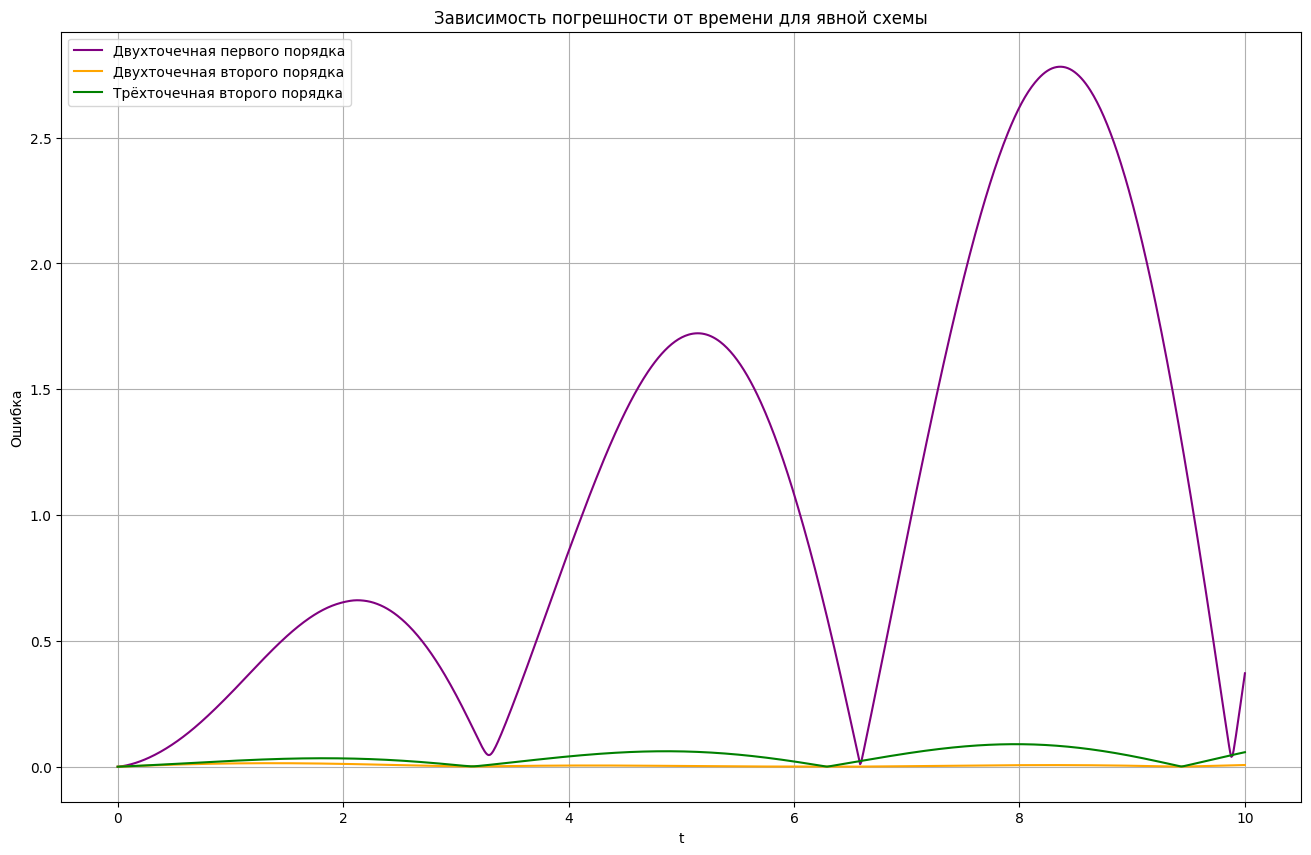

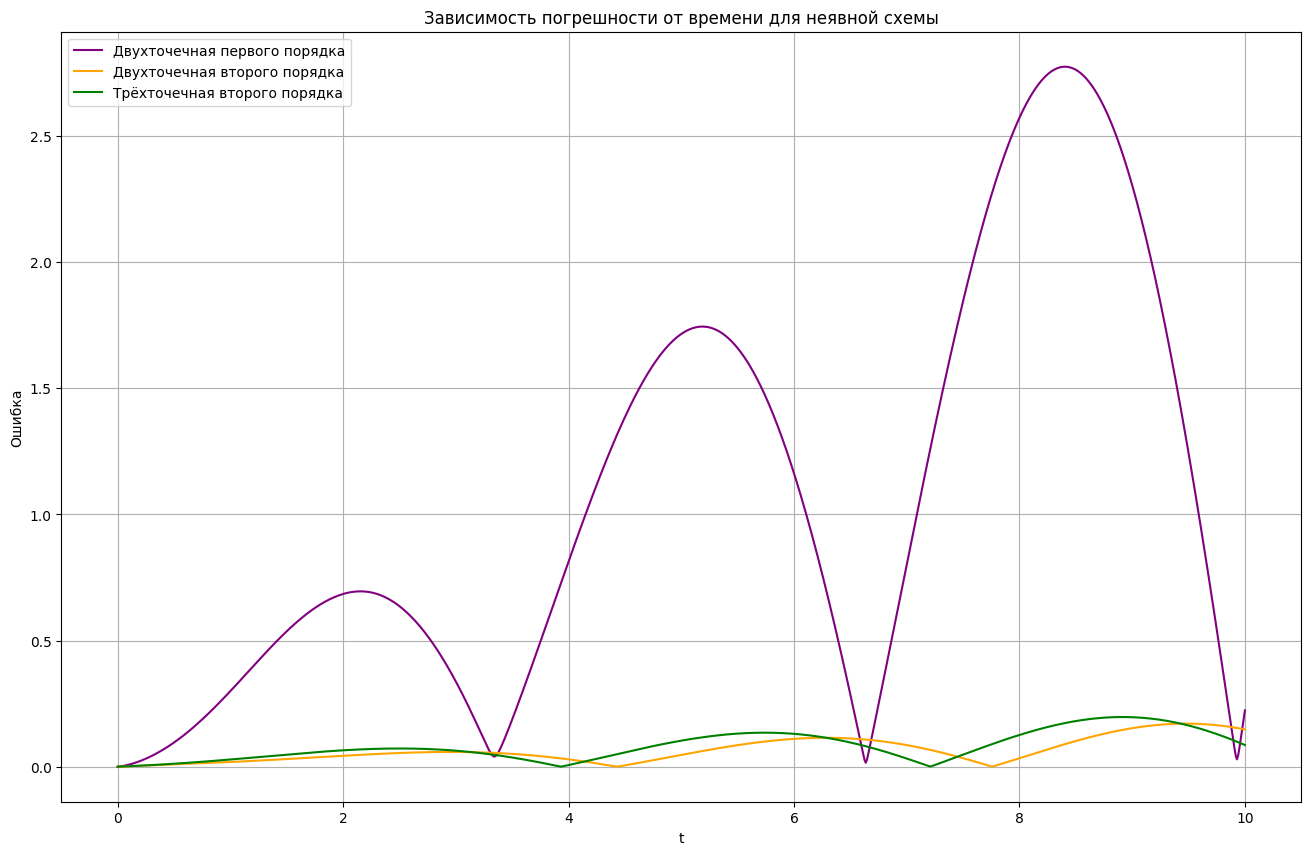

In [17]:
# Явная схема
plot_error_by_t(
    scheme_function=explicit_scheme,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    T=T_difference_by_t,
    exact_solution=exact_by_t,
    K=K,
    title="Зависимость погрешности от времени для явной схемы",
    t=t,
    colors=["purple", "orange", "green"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)

# Неявная схема
plot_error_by_t(
    scheme_function=implict_scheme,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    T=T_difference_by_t,
    exact_solution=exact_by_t,
    K=K,
    title="Зависимость погрешности от времени для неявной схемы",
    t=t,
    colors=["purple", "orange", "green"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трёхточечная второго порядка"]
)

## Построение графиков зависимости погрешности от h

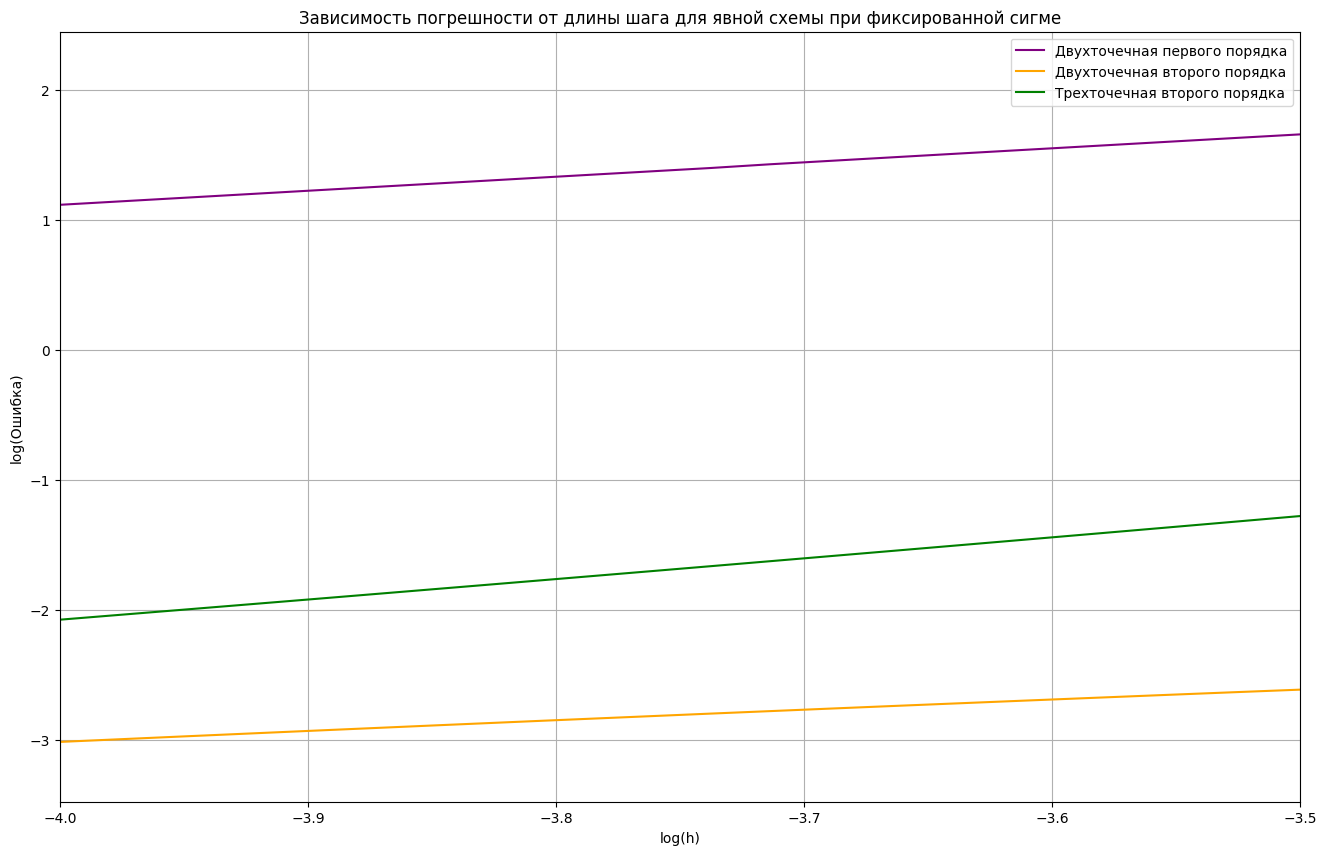

Углы наклона логарифмических графиков ошибок для каждой аппроксимационной схемы:
Двухточечная первого порядка: 1.0183
Двухточечная второго порядка: 0.7454
Трехточечная второго порядка: 1.6253


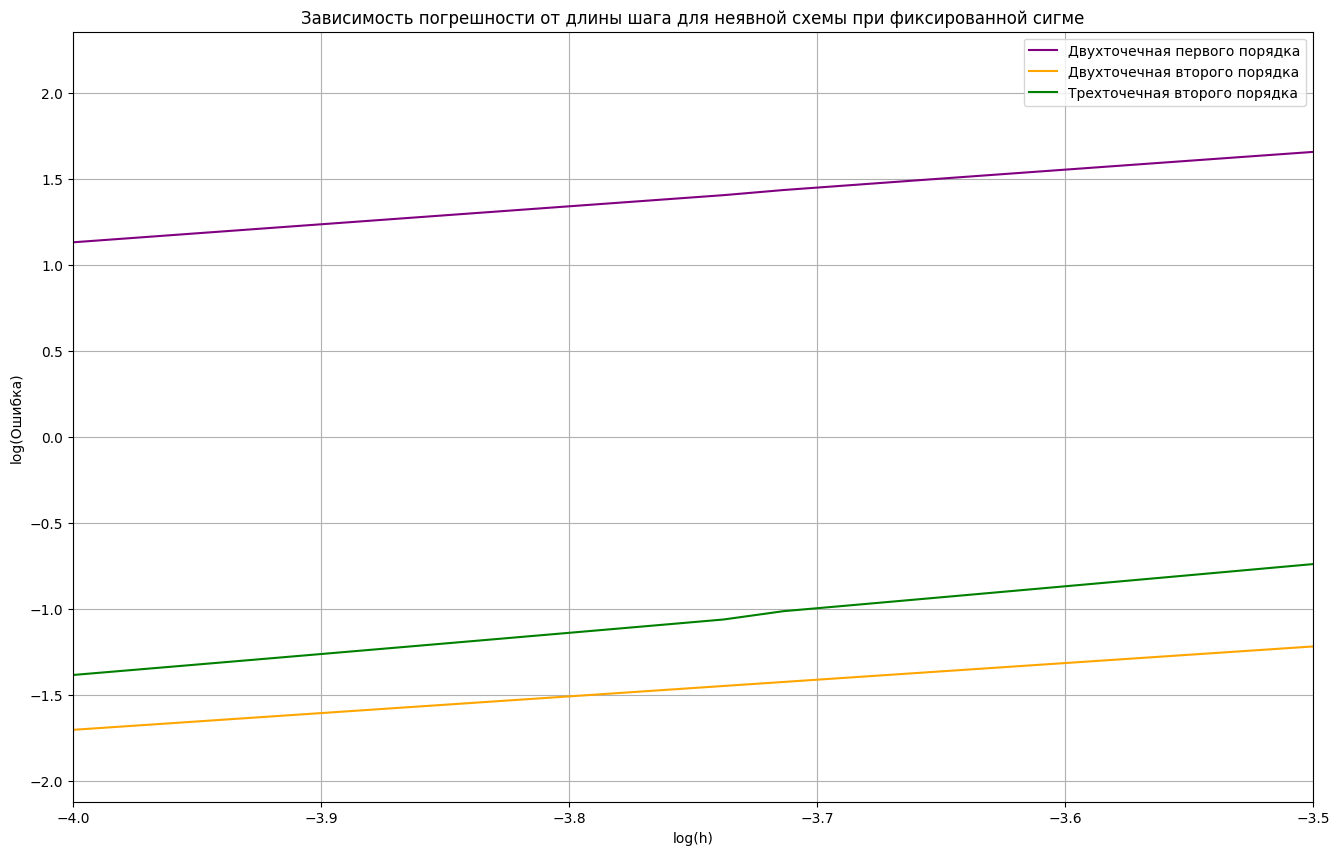

Углы наклона логарифмических графиков ошибок для каждой аппроксимационной схемы:
Двухточечная первого порядка: 0.9806
Двухточечная второго порядка: 0.9665
Трехточечная второго порядка: 1.2960


In [18]:
# Явная схема
plot_error_by_h(
    scheme_function=explicit_scheme,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    T=5,
    exact_solution=exact_by_h,
    sigma=0.7,
    title="Зависимость погрешности от длины шага для явной схемы при фиксированной сигме",
    colors=["purple", "orange", "green"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трехточечная второго порядка"]
)

# Неявная схема
plot_error_by_h(
    scheme_function=implict_scheme,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    T=5,
    exact_solution=exact_by_h,
    sigma=0.7,
    title="Зависимость погрешности от длины шага для неявной схемы при фиксированной сигме",
    colors=["purple", "orange", "green"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трехточечная второго порядка"]
)

## Построение графиков с разными типами аппроксимации

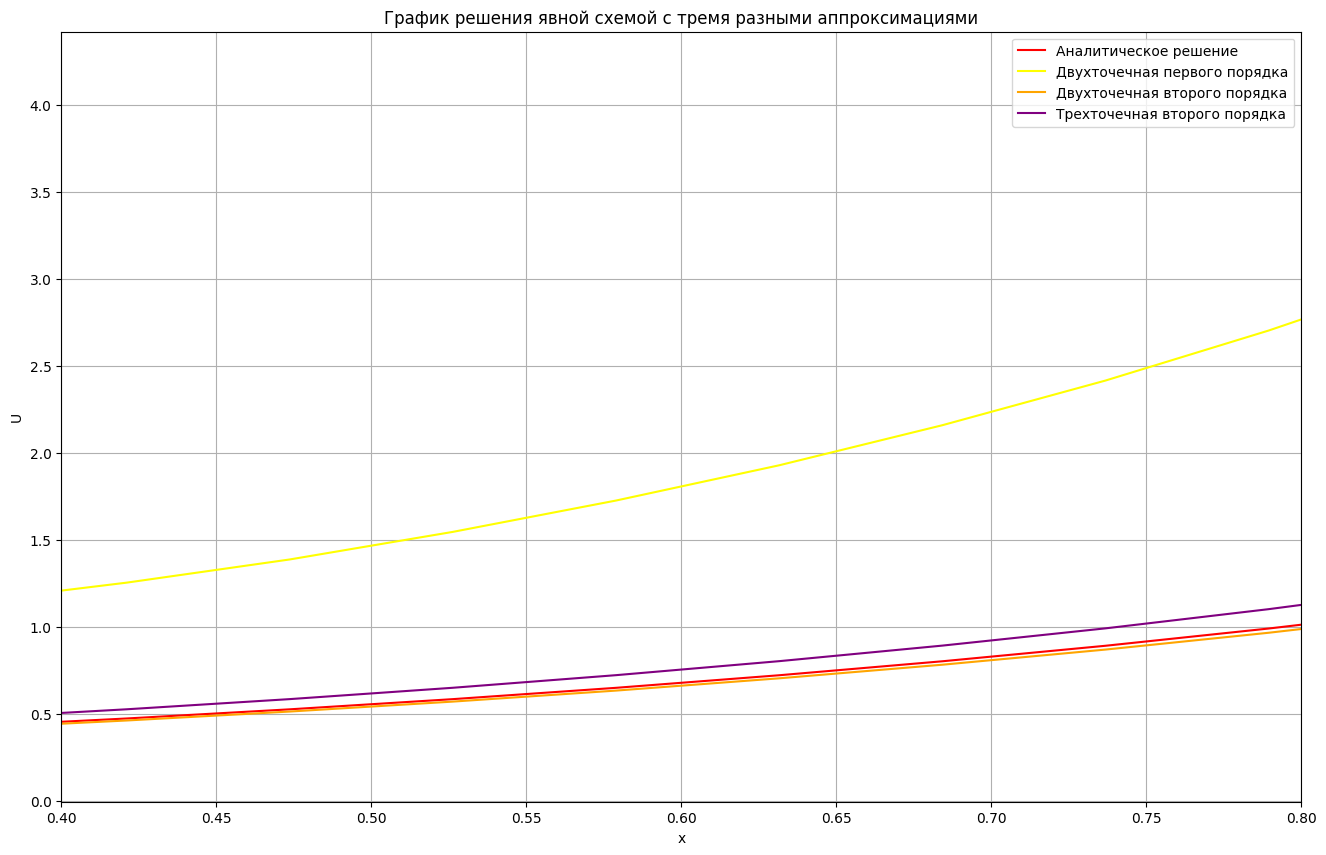

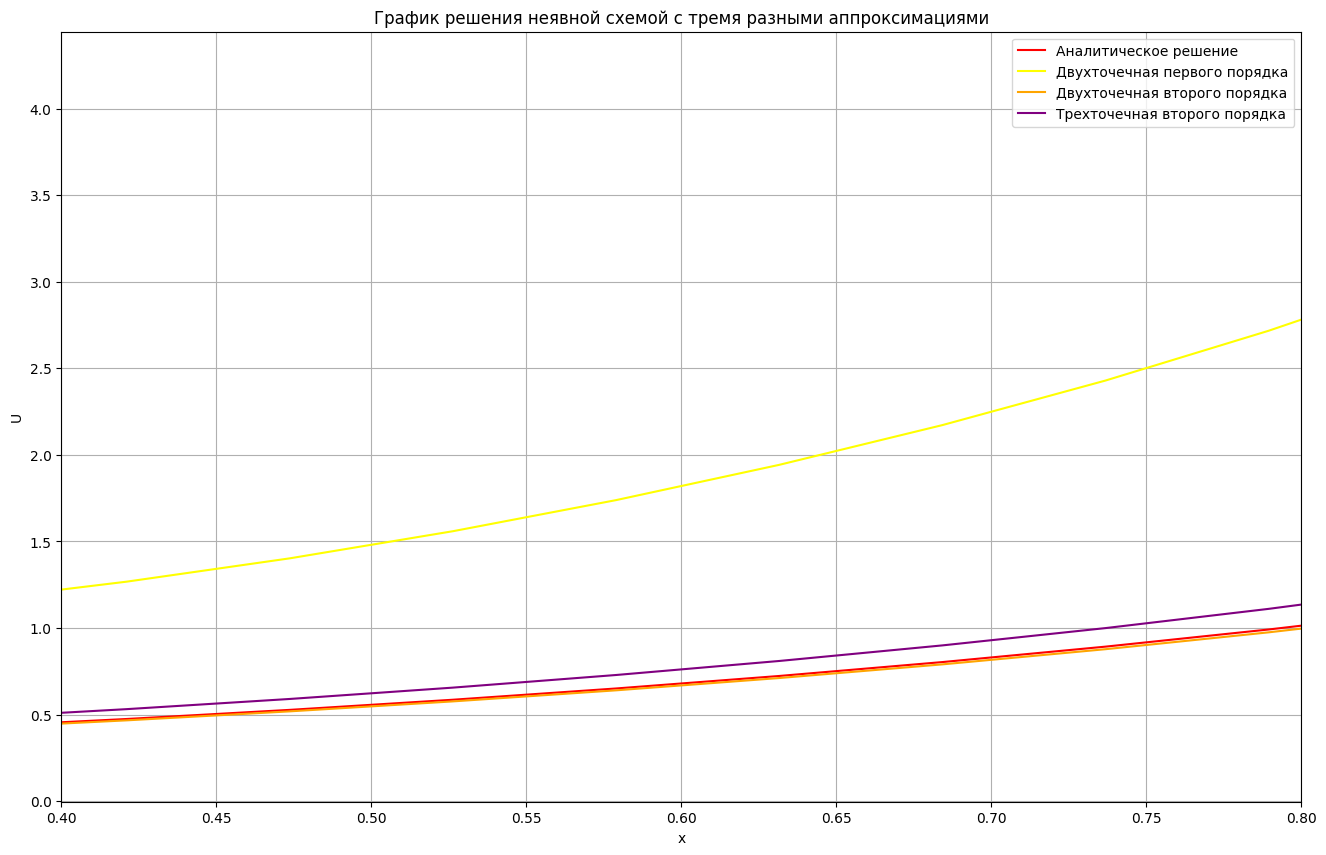

In [19]:
# Явная схема
plot_approx(
    scheme_function=explicit_scheme,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    N=N,
    x=x,
    exact_solution=exact_approx_ans,
    T=300,
    title="График решения явной схемой с тремя разными аппроксимациями",
    colors=["yellow", "orange", "purple"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трехточечная второго порядка"]
)

# Неявная схема
plot_approx(
    scheme_function=implict_scheme,
    approx_schemes=[approx_two_one, approx_two_two, approx_three_two],
    N=N,
    x=x,
    exact_solution=exact_approx_ans,
    T=300,
    title="График решения неявной схемой с тремя разными аппроксимациями",
    colors=["yellow", "orange", "purple"],
    labels=["Двухточечная первого порядка", "Двухточечная второго порядка", "Трехточечная второго порядка"]
)

## Построение графиков с разными T

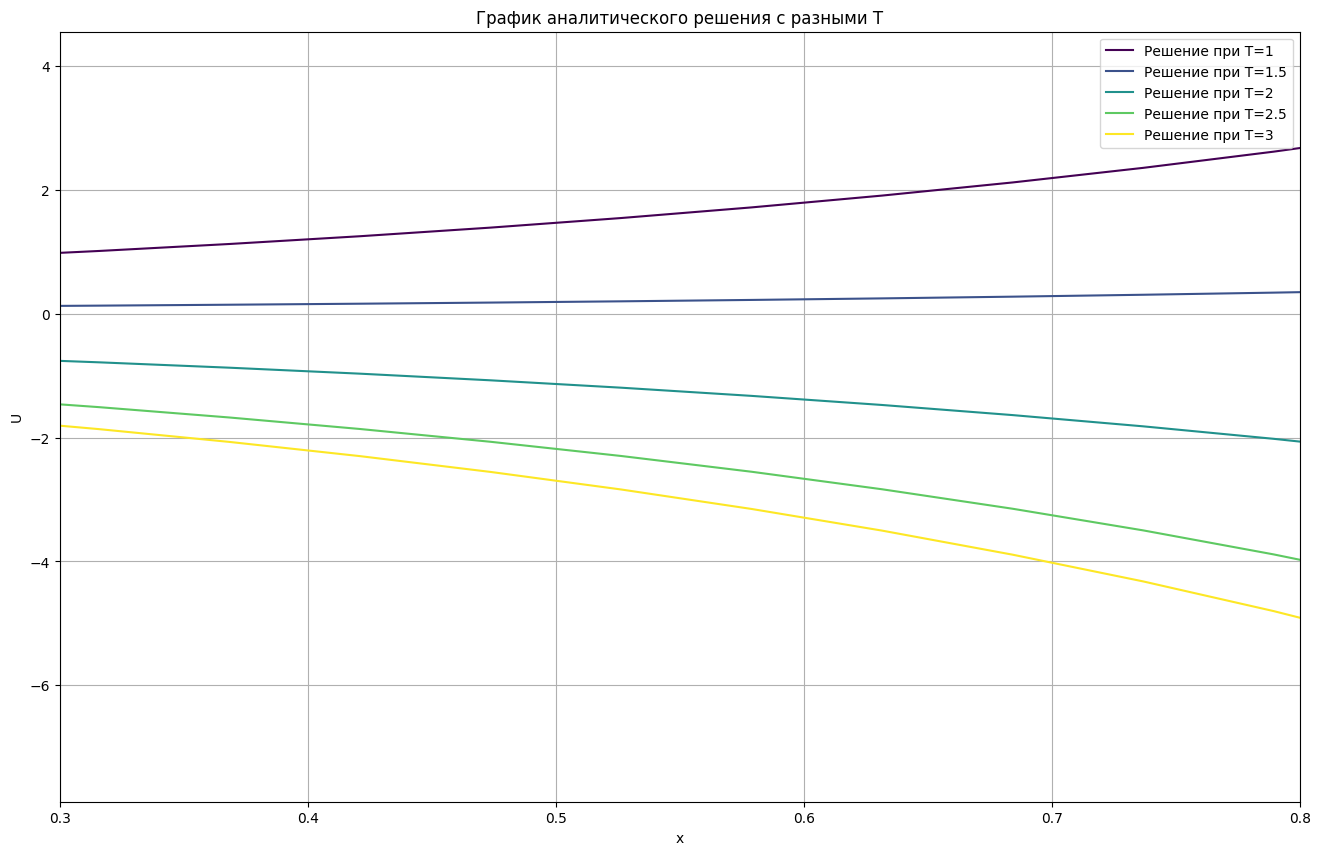

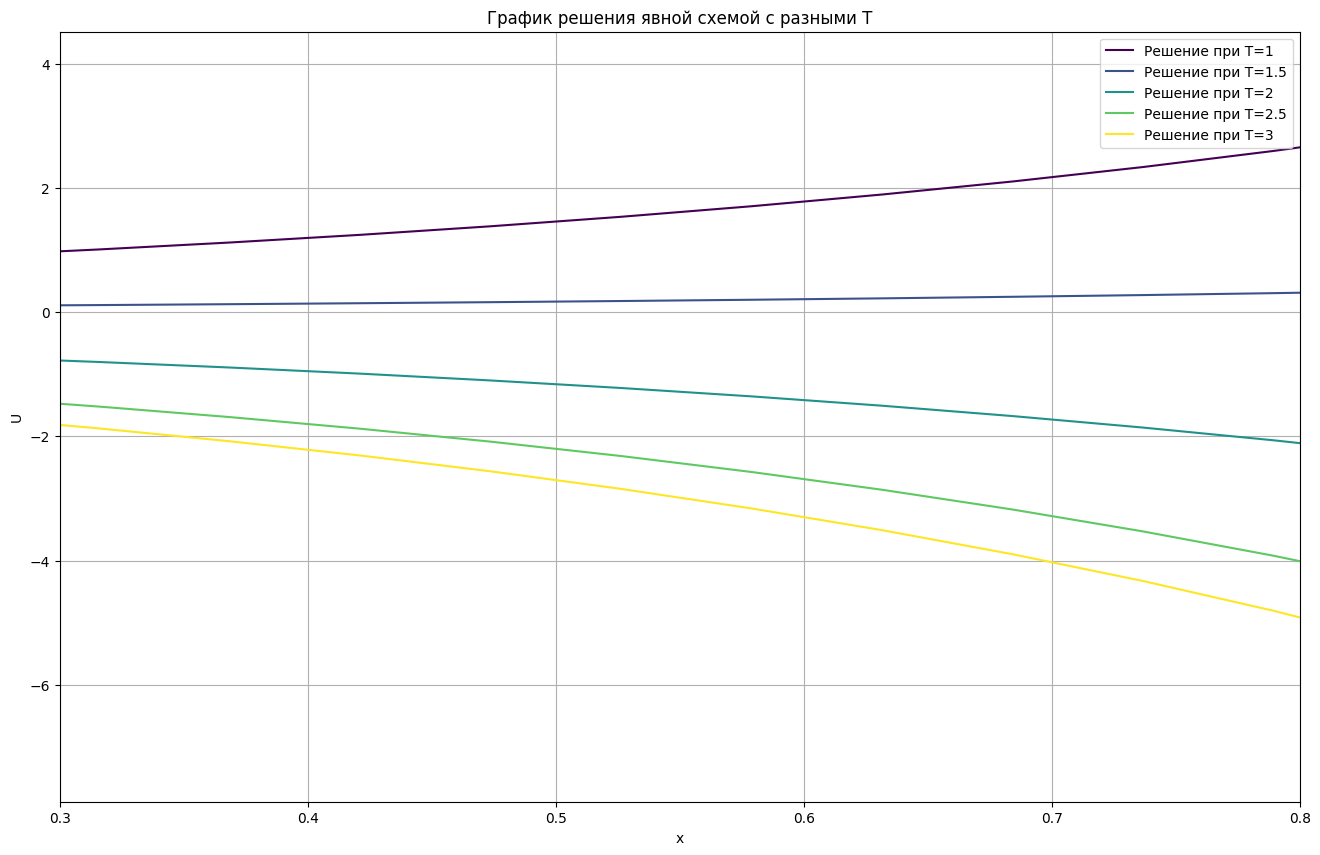

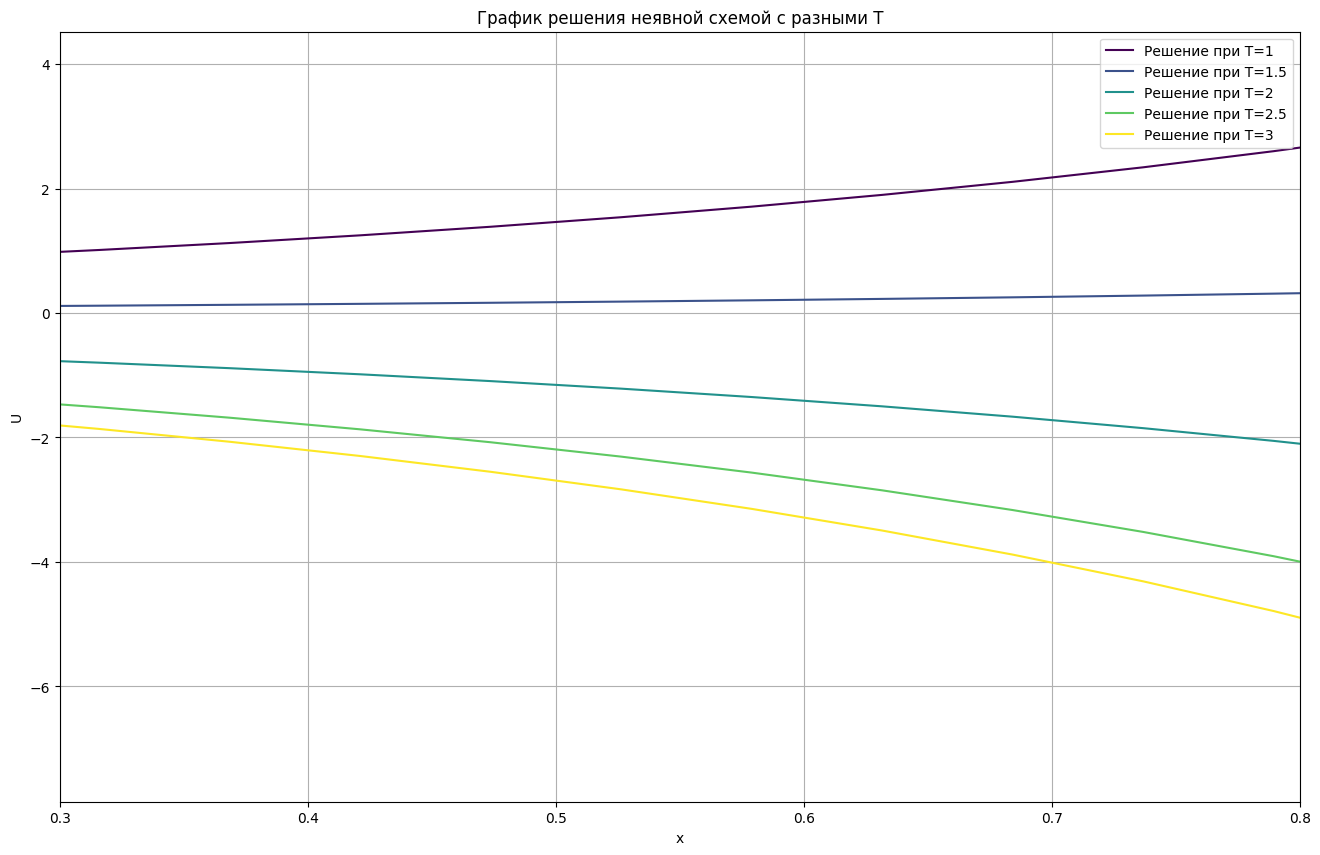

In [20]:
# Аналитическое решение
plot_solutions_with_different_T(
    scheme_function=exact_solution,
    approx_scheme=None,
    T_array=[1, 1.5, 2, 2.5, 3],
    N=N,
    x=x,
    title="График аналитического решения с разными T",
    xlabel="x",
    ylabel="U"
)

# Явная схема
plot_solutions_with_different_T(
    scheme_function=explicit_scheme,
    approx_scheme=approx_two_two,
    T_array=[1, 1.5, 2, 2.5, 3],
    N=N,
    x=x,
    title="График решения явной схемой с разными T",
    xlabel="x",
    ylabel="U"
)

# Неявная схема
plot_solutions_with_different_T(
    scheme_function=implict_scheme,
    approx_scheme=approx_two_two,
    T_array=[1, 1.5, 2, 2.5, 3],
    N=N,
    x=x,
    title="График решения неявной схемой с разными T",
    xlabel="x",
    ylabel="U"
)